# An example of a typical data pipeline in neuroscience

In [1]:
import datajoint as dj
import numpy as np
import pylab as pl
import scipy.optimize as opt
import scipy as sc

from scipy.special import factorial
from scipy import stats

%matplotlib inline

## 1) Defining schema and relational structure

In [2]:
dj.conn()

Please enter DataJoint username: root
Please enter DataJoint password: ········
Connecting root@localhost:3306


DataJoint connection (connected) root@localhost:3306

In [3]:
schema = dj.schema('manual_test')

In [4]:
@schema
class User(dj.Lookup):
    definition = """
    #User information
    user: varchar(20)         #Username
    ---
    first_name : varchar(20)  #User's first name
    last_name : varchar(20)   #User's last name
    """
    
@schema
class Experiment(dj.Manual):
    definition = """ 
    #Experiment
    -> User
    experiment : int          #Experiment number
    """

@schema
class Set(dj.Imported):
    definition = """
    #A set of data
    -> Experiment             
    -----
    vtrace        : longblob         #Voltage values sampled over 50mus
    spike_times    : longblob         #Spiketimes
    spike_voltages : longblob         #SpikeVoltages
    """
    
    def _make_tuples(self, key):
        data_file = np.loadtxt(('./data/{user}_experiment_{experiment}.dat').format(**key))
        vtrace = key['vtrace'] = data_file
        
#         print(data_file)

        tbins = np.arange(0, 60, 0.00005)
        threshold = -5 * np.std(vtrace)

        above = (vtrace < threshold)
        spikes = above[1:] < above[0:-1]

        key['spike_times'] = tbins[np.where(spikes)]
        key['spike_voltages'] = vtrace[np.where(spikes)]
        self.insert1(key)

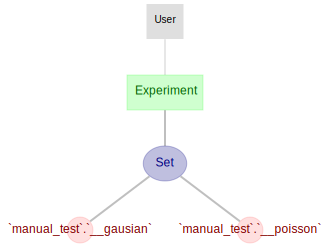

In [5]:
dj.ERD(schema)

To insert entries into the "User" table manually:

In [6]:
num_of_users = int(input('Enter number of users'))

for i in range(num_of_users):
    username = input('Enter your username')
    first_name = input('Enter your first name')
    last_name = input('Enter your last name')
    User.insert1(dict(user=username, first_name=first_name, last_name=last_name))

Enter number of users


ValueError: invalid literal for int() with base 10: ''

Testing:

In [7]:
# Delete entries
# (User() & 'user="user2_manual"').delete()
# type(User.fetch('last_name')[0])
User()

user username,first_name user first name,last_name user last name
Angus,Angus,Macguyver
John,John,Doe
user2_manual,John,Tparty


Enter the number of experiments for each user:


In [ ]:
user_array = User().fetch('user')

for i in range(user_array.size):
    num_of_experiments = int(input('Enter the number of experiments: %s' % user_array[i]))
    for j in range(num_of_experiments):
    Experiment.insert1([user_array[i], j], skip_duplicates = True)

Testing:

In [8]:
Experiment()
Set().populate()

matches = (Set() & 'experiment>-1').fetch('spike_times')
for i in range(Experiment.fetch('experiment').size):
    print('Spike times for experiment #%d:'%(i+1))
    print(matches[i][0:51])
    print('\n')

Spike times for experiment #1:
[ 0.03765  0.36665  0.3674   0.75905  1.38585  1.38655  1.529    2.4852
  3.03125  4.14095  4.14115  4.1418   4.681    4.68165  4.8407   4.9478
  5.3194   5.3201   5.7493   5.75     6.27965  7.2411   7.24185  7.8001
  7.80075  9.2389   9.56995  9.6104   9.7667   9.78025 10.1078  10.8707
 10.9518  10.95245 11.5262  11.52695 13.7053  13.71505 14.39185 14.3926
 14.72445 14.7252  15.49325 15.494   15.5317  15.74075 16.03255 16.29925
 16.65905 17.1305  17.1312 ]


Spike times for experiment #2:
[ 0.1633   0.16395  1.91675  1.91745  2.0804   2.1637   2.16435  2.9311
  3.4042   4.0434   4.08705  4.4291   4.4298   4.6126   4.6133   4.92135
  5.22765  5.67245  6.1407   6.1413   6.14545  6.38525  6.386    6.9266
  6.92715  7.2594   7.55235  7.55305  7.5612   7.56185  8.1486   8.1494
  8.4111   8.63615  8.63685  9.51335  9.51405  9.52475  9.659    9.75995
 10.2294  10.41245 10.4792  11.33015 11.3891  12.19865 12.481   12.75555
 13.3334  13.46405 13.4648 ]


Spike ti

## 2) Loading and plotting the data

First, we have to load the data from a directory. This specific file contains voltage values as function of time. What is measured is the volFirst, we have to load the data from a directory. This specific file contains voltage values as function of time. What is measured is the voltage value close to an electrically active cells, a brain cell, as a function of time. The data format is raw text and the sampling is done at 50 mus per voltage value 

__Update__: The vtrace data is being fetched from the databasetage value close to an electrically active cells, a brain cell, as a function of time. The data format is raw text and the sampling is done at 50 mus per voltage value

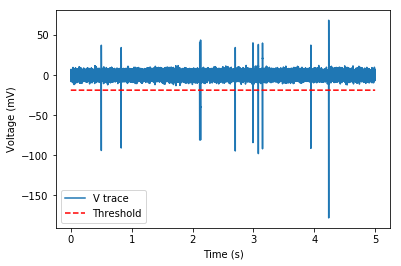

In [10]:
Vtrace = (Set() & 'user="john"' & 'experiment = "0"').fetch('vtrace')[0] # './data/john_experiment_0.dat'
tbins = np.arange(0, 60, 0.00005) # 1 min recording with 50mu s sampling

pl.plot(tbins[0:100000], Vtrace[0:100000], label = 'V trace')
threshold = -5 * np.std(Vtrace)

pl.plot(tbins[0:100000], np.ones(100000)*threshold, '--r', label = 'Threshold')
pl.xlabel('Time (s)')
pl.ylabel('Voltage (mV)')
pl.legend()

The data shows a measurement of a voltage as function of time. In addition to a noisy baseline, there are sharp peaks visible. These so-called spikes constitute the fundamental unit of electrical activity of nerve cells. The rest of this notebook is concerned with the extraction and analysis of these spikes.


## 3) Extractig spikes: the central object in the dataset

The simplest method to identify spikes in a dataset is thresholding the numbers, and identifying the timepoints where the voltage exceeded some threshold. Here is is set to -40, but this number can be found automatically, e.g. by setting it to -np.std(Vtrace).

Text(0, 0.5, 'Voltage (mV)')

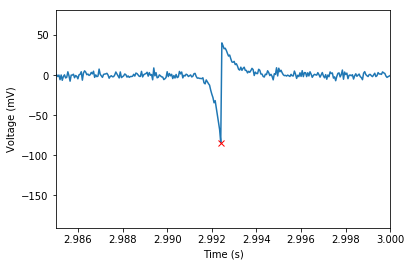

In [11]:
spikeTimes = (Set() & 'user="john"' & 'experiment = "0"').fetch('spike_times')[0]
spikeVoltages = (Set() & 'user="john"' & 'experiment = "0"').fetch('spike_voltages')[0]

pl.plot(tbins, Vtrace, spikeTimes, spikeVoltages, 'xr')
pl.xlim([2.985, 3.0])
pl.xlabel('Time (s)')
pl.ylabel('Voltage (mV)')

The plot shows a typical spike: a short biphasic voltage pulse about 2ms long.

Now that the spiketimes [i.e. the times when a spike occured] have been saved, we can study some of their statistical properties.

## 4) Spike time analysis

Gausian fit:

In [12]:
@schema
class Gausian(dj.Computed):
    definition = """
    ->Set
    -----
    datafitted: longblob   
    """

    def normpdf(x, mu, sd, denom):
        num = np.exp(-(x-mu)**2/(2*sd*sd))
        return num/denom

    def _make_tuples(self, key):
        spikeTimes = (Set() & 'user="john"' & 'experiment = "0"').fetch('spike_times')[0]
        ISI = np.diff(spikeTimes)

        ISIhist = pl.hist(ISI*1000, 30)
        probabilities = ISIhist[0]/np.sum(ISIhist[0])
        distance_between_spikes = ISIhist[1][:-1]

        popt, pcov = opt.curve_fit(Gausian.normpdf, np.log(distance_between_spikes), probabilities)
        data_fitted = Gausian.normpdf(np.log(distance_between_spikes), *popt)
        
        key['datafitted'] = data_fitted
        self.insert1(key)

Poisson fit:

In [15]:
@schema
class Poisson(dj.Computed):
    definition = """
        ->Set
        -----
        datafitted: longblob
        """
    
    def poissonpdf(k, lamb):
        return (lamb**k/factorial(k)) * np.exp(-lamb)

    def _make_tuples(self, key):

        # get poisson deviated random numbers
        spikeTimes = (Set() & 'user="john"' & 'experiment = "0"').fetch('spike_times')[0]

        ISI = np.diff(spikeTimes)

        # the bins should be of integer width, because poisson is an integer distribution
        entries, bin_edges, patches = pl.hist(ISI*1000, bins=30)

        # calculate binmiddles
        bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

        # fit with curve_fit
        parameters, cov_matrix = opt.curve_fit(Poisson.poissonpdf, bin_middles, entries) 

        # plot poisson-deviation with fitted parameter
        x_plot = np.linspace(0, 20, 1000)
        key['datafitted'] = x_plot
        
        self.insert1(key)
        pl.plot(x_plot, Poisson.poissonpdf(x_plot, *parameters), 'r-', lw=2)
        pl.show()

Testing Gausian:

user username,experiment,datafitted
Angus,0,=BLOB=
Angus,1,=BLOB=
Angus,2,=BLOB=
John,0,=BLOB=
John,1,=BLOB=
John,2,=BLOB=
John,3,=BLOB=
John,4,=BLOB=


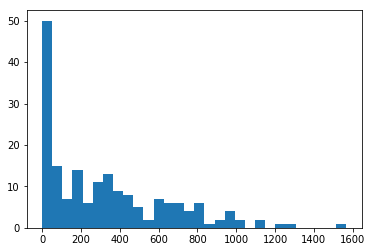

In [16]:
Gausian().populate()
Gausian()

Testing Poisson:

C:\Users\bhrgv_knp\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


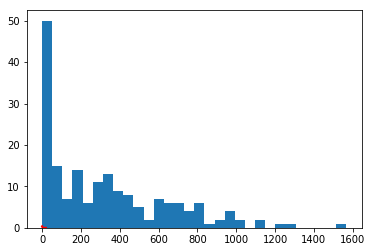

user username,experiment,datafitted
Angus,0,=BLOB=
Angus,1,=BLOB=
Angus,2,=BLOB=
John,0,=BLOB=
John,1,=BLOB=
John,2,=BLOB=
John,3,=BLOB=
John,4,=BLOB=


In [17]:
Poisson().populate()
Poisson()

This modelpipeline ends here. We have ingested the raw data, identified spikes, calculated the inter spike intervals, and fitted a model function to it. In the remaining exercise, we will translate this pipeline into one of the standard forms in neuroscience.